In [1]:
%%configure -f
{"conf": {"spark.pyspark.python":"/home/hadoop/path/to/venv/bin/python3"}}

# <font color='darkblue'>Sparkify Full Dataset Profiling</font>

- In this notebook we investigate the full dataset which is about 12GB. 
    
- This notebook has PySpark kernel and it is designed for AWS EMR.

In [2]:
# check the available memory in the cluster
print('Available AWS-EMR Memory: {}'.format(spark.sparkContext
                                            .getConf().get('spark.driver.memory')))

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1641692119213_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Available AWS-EMR Memory: 11171M

## <font color='blue'>Import Libraries</font>

In [3]:
# import neccessary libraries and packages

from pyspark import SparkContext
from pyspark import SparkConf

from pyspark.sql import SparkSession
from pyspark.sql.types import (
    StringType,
    IntegerType, 
    DateType, 
    TimestampType,
    )

from pyspark.sql.functions import (
    min as Fmin, max as Fmax, 
    sum as Fsum, round as Fround, 
    col, desc, asc,
    count, countDistinct, 
    when, lit, lag, lead,
    isnull, isnan,
    from_unixtime, dayofmonth, month, hour,
    date_format,
    first, last, split,
    )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# create a Spark session

spark = SparkSession \
        .builder \
        .appName("Sparkify") \
        .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# import scipy libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## <font color='blue'>Load the Dataset</font>

In [6]:
def load_data(file_path):
    """
    Loads the raw dataset in Spark.
    
    INPUT:
            (str) - path for datafile
    OUTPUT:
            (PySpark dataframe) - dataframe of raw data
    
    """
    
    print("Loading the dataset ...")
    df = spark.read.json(file_path)
    print("Dataset is loaded ...")
    
    return df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# create a path variable for the full dataset file
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# load the dataset 
df = load_data(event_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Loading the dataset ...
Dataset is loaded ...

## <font color='blue'>Preliminary Investigation</font>

In [9]:
# count null values in each column
df.select([count(when(isnan(c) | col(c).isNull(), c)) \
           .alias(c) for c in df.columns]) \
           .show(vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0----------------
 artist        | 5408927 
 auth          | 0       
 firstName     | 778479  
 gender        | 778479  
 itemInSession | 0       
 lastName      | 778479  
 length        | 5408927 
 level         | 0       
 location      | 778479  
 method        | 0       
 page          | 0       
 registration  | 778479  
 sessionId     | 0       
 song          | 5408927 
 status        | 0       
 ts            | 0       
 userAgent     | 778479  
 userId        | 0

In [10]:
# count distinct entries in each column
df.select([countDistinct(c) \
           .alias(c) for c in df.columns]) \
           .show(vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0----------------
 artist        | 38337   
 auth          | 4       
 firstName     | 5467    
 gender        | 2       
 itemInSession | 1429    
 lastName      | 1000    
 length        | 23748   
 level         | 2       
 location      | 886     
 method        | 2       
 page          | 22      
 registration  | 22247   
 sessionId     | 228713  
 song          | 253564  
 status        | 3       
 ts            | 5191762 
 userAgent     | 85      
 userId        | 22278

## <font color='blue'>Univariate Analysis</font>

### <font color='blue'>userId Column</font>

In [11]:
# the number of distinct userId stored in the dataset 
df.select(countDistinct("userId").alias("countIds")).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+
|countIds|
+--------+
|   22278|
+--------+

In [12]:
# count rows by userId to retrieve how many rows have missing userId
userId_counts = df.groupBy("userId").count().orderBy("userId")
userId_counts.show(4)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----+
| userId|count|
+-------+-----+
|1000025| 2005|
|1000035| 1577|
|1000083|  596|
|1000103|   95|
+-------+-----+
only showing top 4 rows

### <font color='blue'>gender Column</font>

In [13]:
# the entries in gender column indicate user's gender
df.groupBy("gender").count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+--------+
|gender|   count|
+------+--------+
|  null|  778479|
|     M|13299562|
|     F|12181158|
+------+--------+

In [14]:
# gender data counts and percentages, excludes null values

df_gender = df \
            .filter(col("gender").isNotNull()) \
            .groupby('gender') \
            .agg((count('gender')) \
            .alias('count'),
                 (Fround(count('gender') / df.count(), 2)*100) \
                 .alias('percentage'))
df_gender.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+--------+----------+
|gender|   count|percentage|
+------+--------+----------+
|     M|13299562|      51.0|
|     F|12181158|      46.0|
+------+--------+----------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

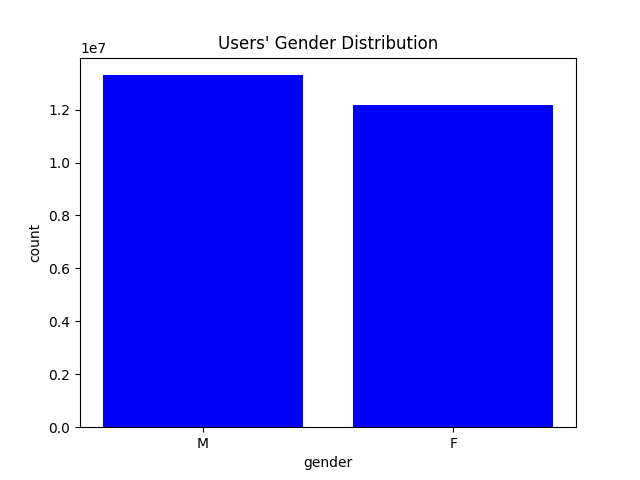

In [19]:
# barplot for gender distribution

# rewrite data as pandas dataframe
data_gender = df_gender.toPandas()

# return the series having unique values
x = data_gender['gender'].unique()
# return the series having frequency counts
y = data_gender['count']

# plot the bar chart
plt.bar(x, y, color='b')

# label the axes
plt.xlabel('gender')
plt.ylabel('count')

# create the title
plt.title("Users' Gender Distribution");

# display the plot
%matplot plt

### <font color='blue'>location Column</font>

In [20]:
# split the location column in two columns: city and state
df = df.withColumn("city", split(df["location"], ",").getItem(0)) \
        .withColumn("state", split(df["location"], ",").getItem(1))

df.show(1, truncate=True, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0-----------------------------
 artist        | Popol Vuh            
 auth          | Logged In            
 firstName     | Shlok                
 gender        | M                    
 itemInSession | 278                  
 lastName      | Johnson              
 length        | 524.32934            
 level         | paid                 
 location      | Dallas-Fort Worth... 
 method        | PUT                  
 page          | NextSong             
 registration  | 1533734541000        
 sessionId     | 22683                
 song          | Ich mache einen S... 
 status        | 200                  
 ts            | 1538352001000        
 userAgent     | "Mozilla/5.0 (Win... 
 userId        | 1749042              
 city          | Dallas-Fort Worth... 
 state         |  TX                  
only showing top 1 row

In [21]:
# determine how many states, regions are there
df.select([countDistinct(df.state)]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------+
|count(DISTINCT state)|
+---------------------+
|                  100|
+---------------------+

In [22]:
# take a look at the distribution of sessions by state
df.groupBy("state").count().sort(desc("count")).show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-------+
|    state|  count|
+---------+-------+
|       CA|3319191|
|       TX|2027031|
| NY-NJ-PA|1732380|
|       FL|1609066|
|       MI| 804841|
|     null| 778479|
|       OH| 767960|
| IL-IN-WI| 725147|
|       GA| 694680|
|       AZ| 653779|
+---------+-------+
only showing top 10 rows

In [23]:
# count the users by state

user_by_state = df.groupBy(["state"]).agg(countDistinct("userId").alias("count"))
user_by_state.sort(desc("count")).show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----+
|    state|count|
+---------+-----+
|       CA| 2804|
|       TX| 1815|
| NY-NJ-PA| 1570|
|       FL| 1423|
|       OH|  703|
| IL-IN-WI|  682|
|       MI|  670|
|       GA|  622|
|       PA|  546|
|       WA|  504|
+---------+-----+
only showing top 10 rows

### <font color='blue'>level Column</font>

In [24]:
# level counts and percentages, to distinguish between paid and free tier

df_level = df \
            .filter(col("level").isNotNull()) \
            .groupby("level") \
            .agg((count("level")) \
            .alias("count"),
                 (Fround(count("level") / df.count(), 2)*100) \
                 .alias("percentage"))

df_level.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------+----------+
|level|   count|percentage|
+-----+--------+----------+
| free| 5663371|      22.0|
| paid|20595828|      78.0|
+-----+--------+----------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

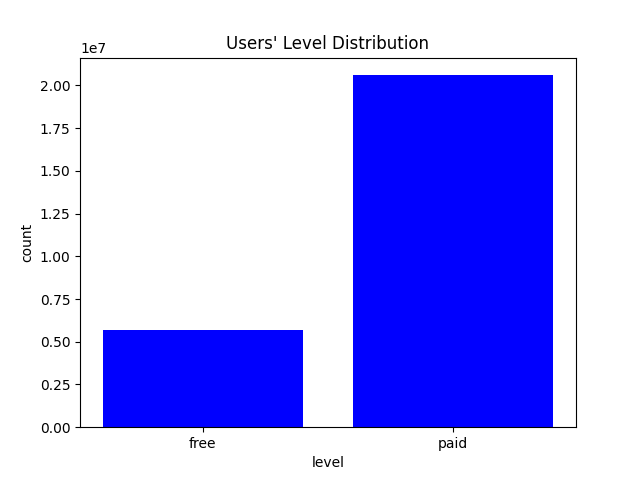

In [26]:
# barplot for level distribution

# rewrite data as pandas dataframe
data_level = df_level.toPandas()

# return the series having unique values
x = data_level['level'].unique()
# return the series having frequency counts
y = data_level['count']

# to avoid stacking plots
plt.clf()

# plot the bar chart
plt.bar(x, y, color='b')

# label the axes
plt.xlabel('level')
plt.ylabel('count')

# create the title
plt.title("Users' Level Distribution");

# display the plot
%matplot plt

### <font color='blue'>registration, ts Columns</font>

In [27]:
# convert the timestamp in registration and ts into datetime format
df = df.withColumn("event_ts", from_unixtime(col("ts")/1000.0))
df = df.withColumn("date_reg", from_unixtime(col("registration")/1000.0))
# check the output
df.select("userId", "sessionId", "registration", "ts", "event_ts", "date_reg").show(4)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+-------------+-------------+-------------------+-------------------+
| userId|sessionId| registration|           ts|           event_ts|           date_reg|
+-------+---------+-------------+-------------+-------------------+-------------------+
|1749042|    22683|1533734541000|1538352001000|2018-10-01 00:00:01|2018-08-08 13:22:21|
|1563081|    20836|1537500318000|1538352002000|2018-10-01 00:00:02|2018-09-21 03:25:18|
|1697168|     4593|1536414505000|1538352002000|2018-10-01 00:00:02|2018-09-08 13:48:25|
|1222580|     6370|1534386660000|1538352003000|2018-10-01 00:00:03|2018-08-16 02:31:00|
+-------+---------+-------------+-------------+-------------------+-------------------+
only showing top 4 rows

In [28]:
# extract day of the month in a separate column
df = df.withColumn("day_ts", dayofmonth(df.event_ts))
df = df.withColumn("day_reg", dayofmonth(df.date_reg))
# check the output
df.select("userId", "sessionId", "event_ts", "date_reg", "day_ts", "day_reg").show(4)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+-------------------+-------------------+------+-------+
| userId|sessionId|           event_ts|           date_reg|day_ts|day_reg|
+-------+---------+-------------------+-------------------+------+-------+
|1749042|    22683|2018-10-01 00:00:01|2018-08-08 13:22:21|     1|      8|
|1563081|    20836|2018-10-01 00:00:02|2018-09-21 03:25:18|     1|     21|
|1697168|     4593|2018-10-01 00:00:02|2018-09-08 13:48:25|     1|      8|
|1222580|     6370|2018-10-01 00:00:03|2018-08-16 02:31:00|     1|     16|
+-------+---------+-------------------+-------------------+------+-------+
only showing top 4 rows

In [29]:
# extract day of the week in words
df=df.withColumn("weekday_ts", date_format(col("event_ts"), "EEEE"))
df=df.withColumn("weekday_reg", date_format(col("date_reg"), "EEEE"))
# check the output
df.select("userId", "sessionId", "event_ts", "date_reg", "weekday_ts", "weekday_reg").show(4)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+-------------------+-------------------+----------+-----------+
| userId|sessionId|           event_ts|           date_reg|weekday_ts|weekday_reg|
+-------+---------+-------------------+-------------------+----------+-----------+
|1749042|    22683|2018-10-01 00:00:01|2018-08-08 13:22:21|    Monday|  Wednesday|
|1563081|    20836|2018-10-01 00:00:02|2018-09-21 03:25:18|    Monday|     Friday|
|1697168|     4593|2018-10-01 00:00:02|2018-09-08 13:48:25|    Monday|   Saturday|
|1222580|     6370|2018-10-01 00:00:03|2018-08-16 02:31:00|    Monday|   Thursday|
+-------+---------+-------------------+-------------------+----------+-----------+
only showing top 4 rows

In [30]:
# extract month from date
df = df.withColumn("month_ts",month(df.event_ts))
df = df.withColumn("month_reg",month(df.date_reg))
# check the output
df.select("userId", "sessionId", "event_ts", "date_reg", "month_ts", "month_reg").show(4)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+-------------------+-------------------+--------+---------+
| userId|sessionId|           event_ts|           date_reg|month_ts|month_reg|
+-------+---------+-------------------+-------------------+--------+---------+
|1749042|    22683|2018-10-01 00:00:01|2018-08-08 13:22:21|      10|        8|
|1563081|    20836|2018-10-01 00:00:02|2018-09-21 03:25:18|      10|        9|
|1697168|     4593|2018-10-01 00:00:02|2018-09-08 13:48:25|      10|        9|
|1222580|     6370|2018-10-01 00:00:03|2018-08-16 02:31:00|      10|        8|
+-------+---------+-------------------+-------------------+--------+---------+
only showing top 4 rows

In [31]:
# get session hour from timestamp
df = df.withColumn("hour_ts",hour(df.event_ts))
# check the output
df.select("userId", "sessionId", "event_ts", "date_reg", "hour_ts").show(4)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+-------------------+-------------------+-------+
| userId|sessionId|           event_ts|           date_reg|hour_ts|
+-------+---------+-------------------+-------------------+-------+
|1749042|    22683|2018-10-01 00:00:01|2018-08-08 13:22:21|      0|
|1563081|    20836|2018-10-01 00:00:02|2018-09-21 03:25:18|      0|
|1697168|     4593|2018-10-01 00:00:02|2018-09-08 13:48:25|      0|
|1222580|     6370|2018-10-01 00:00:03|2018-08-16 02:31:00|      0|
+-------+---------+-------------------+-------------------+-------+
only showing top 4 rows

In [32]:
# take a look at the statistics for the two columns registration and ts
reg_ts = df.describe("registration", "ts")
reg_ts.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+--------------------+
|summary|        registration|                  ts|
+-------+--------------------+--------------------+
|  count|            25480720|            26259199|
|   mean|1.535220665260512...|1.540905636113772...|
| stddev| 3.240299097825069E9|1.5158105552718587E9|
|    min|       1508018725000|       1538352001000|
|    max|       1543821822000|       1543622402000|
+-------+--------------------+--------------------+

In [33]:
# the earliest and the latest sessions in the dataset
mindate = df.agg(Fmin("event_ts")).toPandas()
maxdate = df.agg(Fmax("event_ts")).toPandas()

# print the start date and the end date of the period in the dataset
print("The first session recorded is on {}.".format(mindate["min(event_ts)"][0]))
print("The last session recorded is on {}.".format(maxdate["max(event_ts)"][0]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The first session recorded is on 2018-10-01 00:00:01.
The last session recorded is on 2018-12-01 00:00:02.

In [34]:
# the earliest and the latest user registration in the dataset
mindatereg = df.agg(Fmin("date_reg")).toPandas()
maxdatereg = df.agg(Fmax("date_reg")).toPandas()

# print the start date and the end date of the period for user registration
print("The first user registration is on {}.".format(mindatereg["min(date_reg)"][0]))
print("The last user registration is on {}.".format(maxdatereg["max(date_reg)"][0]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The first user registration is on 2017-10-14 22:05:25.
The last user registration is on 2018-12-03 07:23:42.

In [35]:
# count sessions by hour
session_by_hour = df.groupBy(["hour_ts"]).agg(countDistinct("sessionId").alias("countSessions"))
session_by_hour.show(24)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------+
|hour_ts|countSessions|
+-------+-------------+
|     12|        66020|
|      1|        62592|
|      6|        57778|
|      3|        59651|
|      4|        58830|
|      8|        58235|
|     11|        63054|
|     19|        76586|
|     23|        66847|
|     21|        71479|
|     14|        74947|
|     16|        80550|
|     20|        74135|
|      5|        58147|
|     15|        78958|
|      2|        60966|
|     18|        78732|
|     13|        70164|
|     17|        80114|
|      7|        57738|
|      0|        64428|
|     22|        68980|
|      9|        58980|
|     10|        60606|
+-------+-------------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

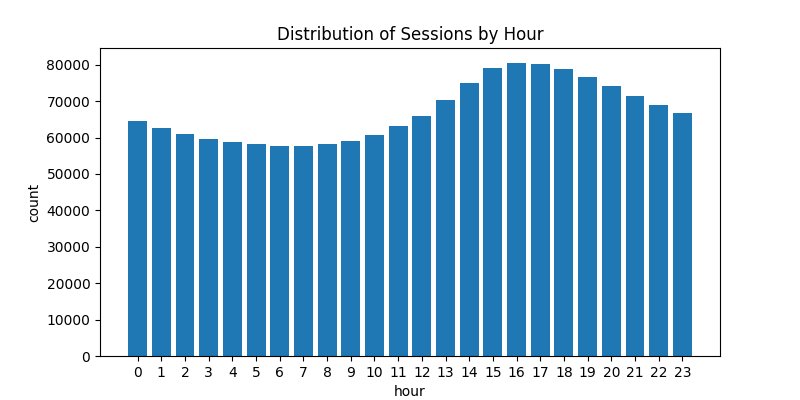

In [36]:
# barplot for sessions by hour distribution

# rewrite data as pandas dataframe
data_hour = session_by_hour.toPandas().sort_values(by="countSessions",
                                              ascending=False)

# return the series having unique values
x = data_hour['hour_ts'].unique()
# return the series having frequency counts
y = data_hour['countSessions']

# to avoid stacking plots
plt.clf()

# set figure size
fig=plt.figure(figsize=(8,4))

# plot the bar chart
plt.bar(x, y)

# label the axes
plt.xlabel('hour')
plt.ylabel('count')
plt.xticks(data_hour.index)

# create the title
plt.title("Distribution of Sessions by Hour");

# display the plot
%matplot plt

In [37]:
# count sessions by day of the week
session_by_weekday = df.groupBy(["weekday_ts"]).agg(countDistinct("sessionId").alias("countSessions"))
session_by_weekday.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------------+
|weekday_ts|countSessions|
+----------+-------------+
| Wednesday|        57703|
|  Saturday|        32499|
|   Tuesday|        57479|
|    Monday|        53990|
|    Sunday|        29359|
|    Friday|        56242|
|  Thursday|        55242|
+----------+-------------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

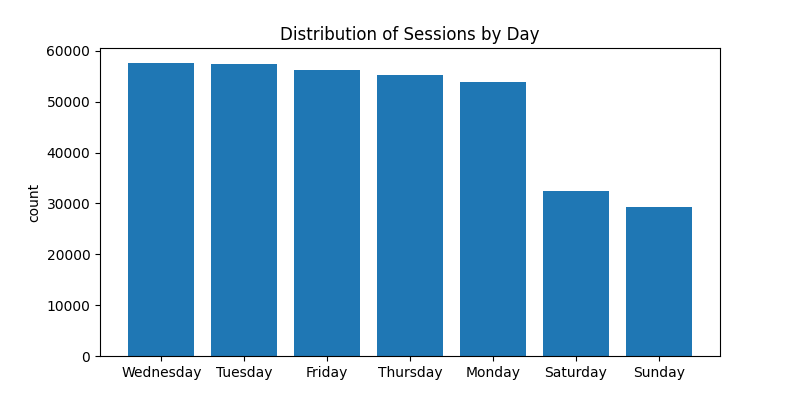

In [38]:
# visualize sessions by day of the week

# rewrite data as pandas dataframe
data_weekday = session_by_weekday.toPandas().sort_values(by="countSessions",
                                              ascending=False)

# return the series having unique values
x = data_weekday['weekday_ts'].unique()
# return the series having frequency counts
y = data_weekday['countSessions']

# to avoid stacking plots
plt.clf()

# set figure size
fig=plt.figure(figsize=(8,4))

# plot the bar chart
plt.bar(x, y)

# label the axes
plt.xlabel('')
plt.ylabel('count')
plt.xticks(data_weekday.index)

# create the title
plt.title("Distribution of Sessions by Day");

# display the plot
%matplot plt

In [39]:
# count sessions by month
session_by_month = df.groupBy(["month_ts"]).agg(countDistinct("sessionId").alias("countSessions"))
session_by_month.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-------------+
|month_ts|countSessions|
+--------+-------------+
|      12|            2|
|      11|       124271|
|      10|       133289|
+--------+-------------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

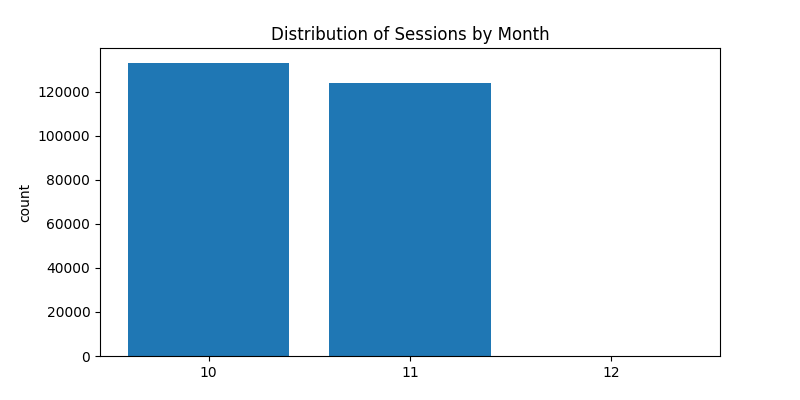

In [40]:
# visualize sessions by month

# rewrite data as pandas dataframe
data_month = session_by_month.toPandas().sort_values(by="countSessions",
                                              ascending=False)

# return the series having unique values
x = data_month['month_ts'].unique()
# return the series having frequency counts
y = data_month['countSessions']

# to avoid stacking plots
plt.clf()

# set figure size
fig=plt.figure(figsize=(8,4))

# plot the bar chart
plt.bar(x, y)

# label the axes
plt.xlabel('')
plt.ylabel('count')

plt.xticks(data_month.month_ts)

# create the title
plt.title("Distribution of Sessions by Month");

# display the plot
%matplot plt

### <font color='blue'>method Column</font>

In [41]:
# the HTTP request method initiated by user, counts and percentages 
df_method = df.groupBy("method").count()
df_method.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+--------+
|method|   count|
+------+--------+
|   GET| 2389761|
|   PUT|23869438|
+------+--------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

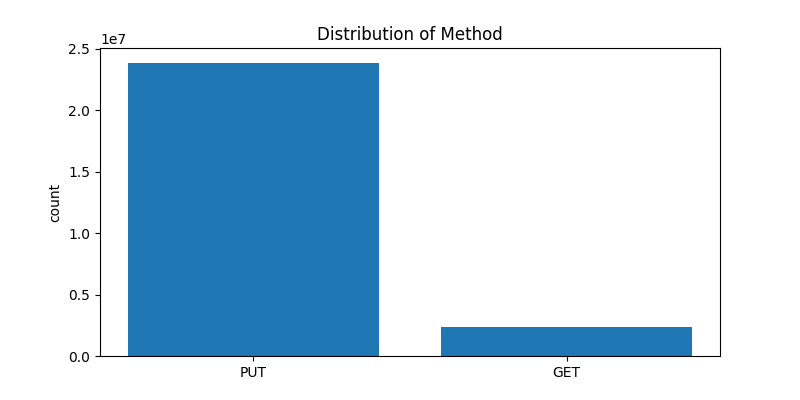

In [42]:
# visualize sessions by method

# rewrite data as pandas dataframe
data_method = df_method.toPandas().sort_values(by="count",
                                              ascending=False)

# return the series having unique values
x = data_method['method'].unique()
# return the series having frequency counts
y = data_method['count']

# to avoid stacking plots
plt.clf()

# plot the bar chart
plt.bar(x, y)

# label the axes
plt.xlabel('')
plt.ylabel('count')

plt.xticks(data_method.method)

# create the title
plt.title("Distribution of Method");

# display the plot
%matplot plt

### <font color='blue'>status Column</font>

In [43]:
# the HTTP status codes distribution
df_status = df.groupBy("status").count()
df_status.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+--------+
|status|   count|
+------+--------+
|   200|23811992|
|   404|   25962|
|   307| 2421245|
+------+--------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

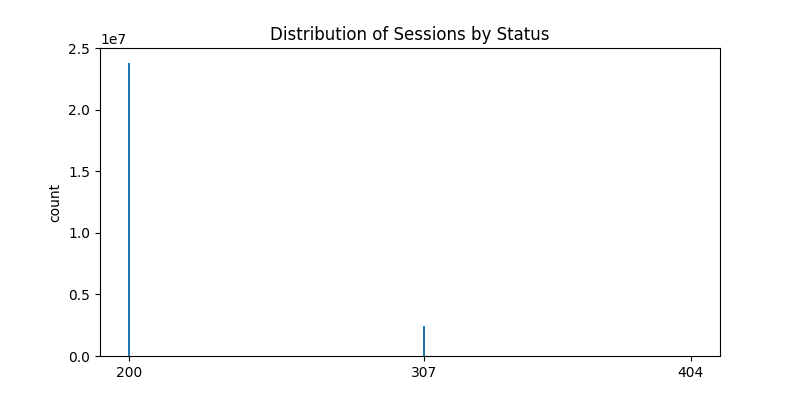

In [44]:
# visualize sessions by status

# rewrite data as pandas dataframe
data_status = df_status.toPandas().sort_values(by="count",
                                              ascending=False)

# return the series having unique values
x = data_status['status'].unique()
# return the series having frequency counts
y = data_status['count']

# to avoid stacking plots
plt.clf()

# plot the bar chart
plt.bar(x, y)

# label the axes
plt.xlabel('')
plt.ylabel('count')

plt.xticks(data_status.status)

# create the title
plt.title("Distribution of Sessions by Status");

# display the plot
%matplot plt

In [45]:
# take a look at the entries that have status 404
df_error = df.filter(df["status"] == 404)
df_error.show(1, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0-----------------------------
 artist        | null                 
 auth          | Logged In            
 firstName     | Anthony              
 gender        | M                    
 itemInSession | 12                   
 lastName      | Diaz                 
 length        | null                 
 level         | paid                 
 location      | New York-Newark-J... 
 method        | GET                  
 page          | Error                
 registration  | 1538045178000        
 sessionId     | 11807                
 song          | null                 
 status        | 404                  
 ts            | 1538352013000        
 userAgent     | "Mozilla/5.0 (Mac... 
 userId        | 1507202              
 city          | New York-Newark-J... 
 state         |  NY-NJ-PA            
 event_ts      | 2018-10-01 00:00:13  
 date_reg      | 2018-09-27 10:46:18  
 day_ts        | 1                    
 day_reg       | 27                   
 weekday_ts    | Monday  

In [46]:
# a look at the other columns when status = 404, count distinct entries in each
df_error.select([countDistinct(c) .alias(c) for c in df.columns]).show(vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0--------------
 artist        | 0     
 auth          | 3     
 firstName     | 3618  
 gender        | 2     
 itemInSession | 713   
 lastName      | 998   
 length        | 0     
 level         | 2     
 location      | 807   
 method        | 1     
 page          | 1     
 registration  | 11261 
 sessionId     | 23070 
 song          | 0     
 status        | 1     
 ts            | 25894 
 userAgent     | 85    
 userId        | 11273 
 city          | 750   
 state         | 100   
 event_ts      | 25894 
 date_reg      | 11261 
 day_ts        | 31    
 day_reg       | 31    
 weekday_ts    | 7     
 weekday_reg   | 7     
 month_ts      | 2     
 month_reg     | 12    
 hour_ts       | 24

In [47]:
# print how many records have status 404
print("There are {} records where the HTTP status is 404, page not found." \
      .format(df_error.count()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

There are 25962 records where the HTTP status is 404, page not found.

In [48]:
# take a look at a paid customers that has status 404
df_error_paid = df_error.filter(df["level"] == "paid")
df_error_paid.show(1, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0-----------------------------
 artist        | null                 
 auth          | Logged In            
 firstName     | Anthony              
 gender        | M                    
 itemInSession | 12                   
 lastName      | Diaz                 
 length        | null                 
 level         | paid                 
 location      | New York-Newark-J... 
 method        | GET                  
 page          | Error                
 registration  | 1538045178000        
 sessionId     | 11807                
 song          | null                 
 status        | 404                  
 ts            | 1538352013000        
 userAgent     | "Mozilla/5.0 (Mac... 
 userId        | 1507202              
 city          | New York-Newark-J... 
 state         |  NY-NJ-PA            
 event_ts      | 2018-10-01 00:00:13  
 date_reg      | 2018-09-27 10:46:18  
 day_ts        | 1                    
 day_reg       | 27                   
 weekday_ts    | Monday  

### <font color='blue'>auth Column</font>

In [49]:
# the entries in auth column indicate the activity type of the user
df_auth = df.groupBy("auth").count()
df_auth.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------+
|      auth|   count|
+----------+--------+
|Logged Out|  774285|
|     Guest|    4194|
| Cancelled|    5003|
| Logged In|25475717|
+----------+--------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

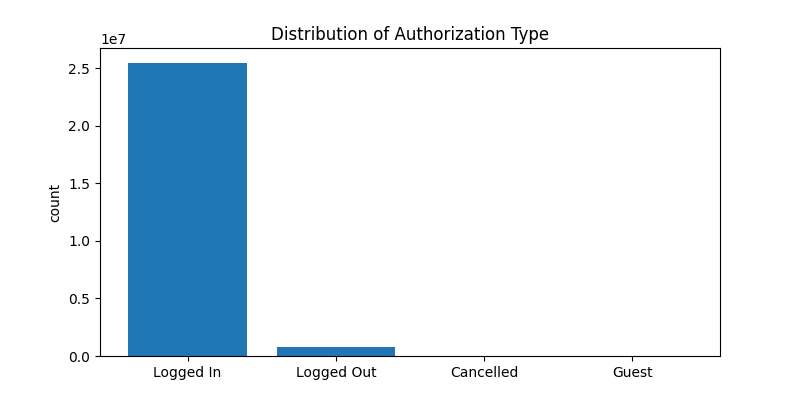

In [50]:
# visualize sessions by authorization

# rewrite data as pandas dataframe
data_auth = df_auth.toPandas().sort_values(by="count",
                                              ascending=False)

# return the series having unique values
x = data_auth['auth'].unique()
# return the series having frequency counts
y = data_auth['count']


# avoid stacking plots
plt.clf()

# plot the bar chart
plt.bar(x, y)

# label the axes
plt.xlabel('')
plt.ylabel('count')

plt.xticks(data_auth.auth)

# create the title
plt.title("Distribution of Authorization Type");

# display the plot
%matplot plt

In [51]:
# take a look at an user that cancelled
df_cancelled = df.filter(df["auth"] == "Cancelled")
df_cancelled.show(1, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0-----------------------------
 artist        | null                 
 auth          | Cancelled            
 firstName     | Harrison             
 gender        | M                    
 itemInSession | 32                   
 lastName      | Turner               
 length        | null                 
 level         | paid                 
 location      | Dayton, OH           
 method        | GET                  
 page          | Cancellation Conf... 
 registration  | 1536683985000        
 sessionId     | 24588                
 song          | null                 
 status        | 200                  
 ts            | 1538360145000        
 userAgent     | Mozilla/5.0 (Wind... 
 userId        | 1768454              
 city          | Dayton               
 state         |  OH                  
 event_ts      | 2018-10-01 02:15:45  
 date_reg      | 2018-09-11 16:39:45  
 day_ts        | 1                    
 day_reg       | 11                   
 weekday_ts    | Monday  

### <font color='blue'>page Column</font>

In [52]:
# most of the actions are on NextSong, then Home and ThumbsUp
df.groupBy("page").count().sort(desc("count")).show(22)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------+
|                page|   count|
+--------------------+--------+
|            NextSong|20850272|
|                Home| 1343102|
|           Thumbs Up| 1151465|
|     Add to Playlist|  597921|
|         Roll Advert|  385212|
|          Add Friend|  381664|
|               Login|  296350|
|              Logout|  296005|
|         Thumbs Down|  239212|
|           Downgrade|  184240|
|                Help|  155100|
|            Settings|  147074|
|               About|   92759|
|             Upgrade|   50507|
|       Save Settings|   29516|
|               Error|   25962|
|      Submit Upgrade|   15135|
|    Submit Downgrade|    6494|
|              Cancel|    5003|
|Cancellation Conf...|    5003|
|            Register|     802|
| Submit Registration|     401|
+--------------------+--------+

### <font color='blue'>length Column</font>

It represents the length of a song, in seconds.

In [53]:
# print descriptive statistics for songs length
df.describe("length").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|          20850272|
|   mean|248.72543296748827|
| stddev|  97.2871038707807|
|    min|             0.522|
|    max|        3024.66567|
+-------+------------------+

### <font color='blue'>itemInSession Column</font>

In [54]:
# print descriptive statistics for itemInSession column
df.describe("itemInSession").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|          26259199|
|   mean|106.56267561702853|
| stddev|  117.658126175238|
|    min|                 0|
|    max|              1428|
+-------+------------------+

In [55]:
# create a dataframe for those data points with itemInSession=0
itemInSession_zero = df.filter(df['itemInSession'] == 0)
# find how many entries have itemInSession = 0
itemInSession_zero.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

306295

In [56]:
# take a look at some of the data with 0 logs in session
itemInSession_zero.show(1, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0-----------------------------
 artist        | Leona Lewis          
 auth          | Logged In            
 firstName     | Jennifer             
 gender        | F                    
 itemInSession | 0                    
 lastName      | Shelton              
 length        | 203.88526            
 level         | free                 
 location      | Pittsburgh, PA       
 method        | PUT                  
 page          | NextSong             
 registration  | 1536455539000        
 sessionId     | 25128                
 song          | Forgive Me           
 status        | 200                  
 ts            | 1538352006000        
 userAgent     | "Mozilla/5.0 (Win... 
 userId        | 1558463              
 city          | Pittsburgh           
 state         |  PA                  
 event_ts      | 2018-10-01 00:00:06  
 date_reg      | 2018-09-09 01:12:19  
 day_ts        | 1                    
 day_reg       | 9                    
 weekday_ts    | Monday  

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

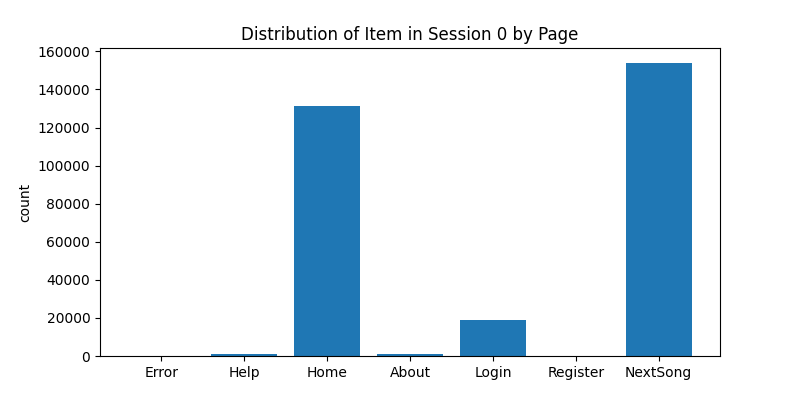

In [57]:
# plot the page usage distribution for zero itemInSession

# create the count dataframe
itemInSession_page = itemInSession_zero.groupby("page").count().toPandas()

# return the series having unique values
x = itemInSession_page['page'].unique()
# return the series having frequency counts
y = itemInSession_page['count']


# set figure size
fig=plt.figure(figsize=(8,4))

# to avoid overlapping plots
plt.clf()

# plot the bar chart
plt.bar(x, y)

# label the axes
plt.xlabel('')
plt.ylabel('count')

plt.xticks(itemInSession_page.page)

# create the title
plt.title("Distribution of Item in Session 0 by Page");

# display the plot
%matplot plt

### <font color='blue'>sessionId Column</font>

In [58]:
# the distribution of sessions by userId
df.groupby("sessionId","userId").count().orderBy("count", ascending=False).show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-------+-----+
|sessionId| userId|count|
+---------+-------+-----+
|    47184|1554671| 1393|
|    84971|1284420| 1385|
|   128347|1805728| 1342|
|    89129|1642682| 1329|
|   143782|1545940| 1292|
|   116166|1449246| 1257|
|   125892|1036574| 1250|
|   225739|1029304| 1198|
|   185100|1190605| 1185|
|    39741|1502571| 1164|
+---------+-------+-----+
only showing top 10 rows

In [59]:
# count distinct userId per session Id
df_sessions = df.groupBy("userId", "sessionId").count().orderBy("count", ascending=False)
# sessions with more than one user - note this does not happen simultaneously
df_sessions.where(df_sessions["count"] != 1).show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+-----+
| userId|sessionId|count|
+-------+---------+-----+
|1554671|    47184| 1393|
|1284420|    84971| 1385|
|1805728|   128347| 1342|
|1642682|    89129| 1329|
|1545940|   143782| 1292|
|1449246|   116166| 1257|
|1036574|   125892| 1250|
|1029304|   225739| 1198|
|1190605|   185100| 1185|
|1502571|    39741| 1164|
+-------+---------+-----+
only showing top 10 rows

In [60]:
# the distribution of sessions by userId
df.groupby("sessionId","userId").count().orderBy("count", ascending=False).show(6)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-------+-----+
|sessionId| userId|count|
+---------+-------+-----+
|    47184|1554671| 1393|
|    84971|1284420| 1385|
|   128347|1805728| 1342|
|    89129|1642682| 1329|
|   143782|1545940| 1292|
|   116166|1449246| 1257|
+---------+-------+-----+
only showing top 6 rows

In [61]:
# example of a sessionId with more than one user associated to it
df.where(df.sessionId=="3").select("userId", "page", "event_ts").show(6)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------------+-------------------+
| userId|           page|           event_ts|
+-------+---------------+-------------------+
|1765220|       NextSong|2018-10-09 15:53:40|
|1765220|       NextSong|2018-10-09 15:56:53|
|1765220|       NextSong|2018-10-09 16:00:51|
|1765220|       NextSong|2018-10-09 16:04:23|
|1765220|       NextSong|2018-10-09 16:09:27|
|1765220|Add to Playlist|2018-10-09 16:09:43|
+-------+---------------+-------------------+
only showing top 6 rows